In [1]:
import seaborn as sns
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D
from tensorflow.keras.optimizers import Adam 
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

2023-09-10 11:11:28.755058: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 11:11:29.579745: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 11:11:29.583222: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 11:11:32.169597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_1174/1036366358.py:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


## Load and Prepare Data

In [2]:
#loading data
train_img = []
train_labels = []

test_img = []
test_labels = []

path_train = ('/mnt/c/Python/IDSS/BTC_inputs/Training/')
path_test = ('/mnt/c/Python/IDSS/BTC_inputs/Testing/')
img_size= 150

#prep data
for i in os.listdir(path_train):
    for j in os.listdir(path_train+i):
        train_img.append (cv2.resize(cv2.imread(path_train+i+'/'+j), (img_size,img_size))) 
        train_labels.append(i)
        
for i in os.listdir(path_test):
    for j in os.listdir(path_test+i):
        test_img.append (cv2.resize(cv2.imread(path_test+i+'/'+j), (img_size,img_size))) 
        test_labels.append(i)

train_img = (np.array(train_img))
test_img = (np.array(test_img))


train_labels_encoded = [0 if category == 'no_tumor' else
                        (1 if category == 'glioma_tumor' else
                         (2 if category=='meningioma_tumor' else
                          3)) for category in list(train_labels)]
test_labels_encoded = [0 if category == 'no_tumor' else
                       (1 if category == 'glioma_tumor' else
                        (2 if category=='meningioma_tumor' else
                         3)) for category in list(test_labels)]

In [3]:
print("Shape of train: ",(train_img).shape," and shape of test: ", (test_img).shape)

Shape of train:  (2870, 150, 150, 3)  and shape of test:  (394, 150, 150, 3)


## Augment the pictures

In [4]:
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

img_datagen.fit(train_img)
img_datagen.fit(test_img)

## Exploratory Data Analysis

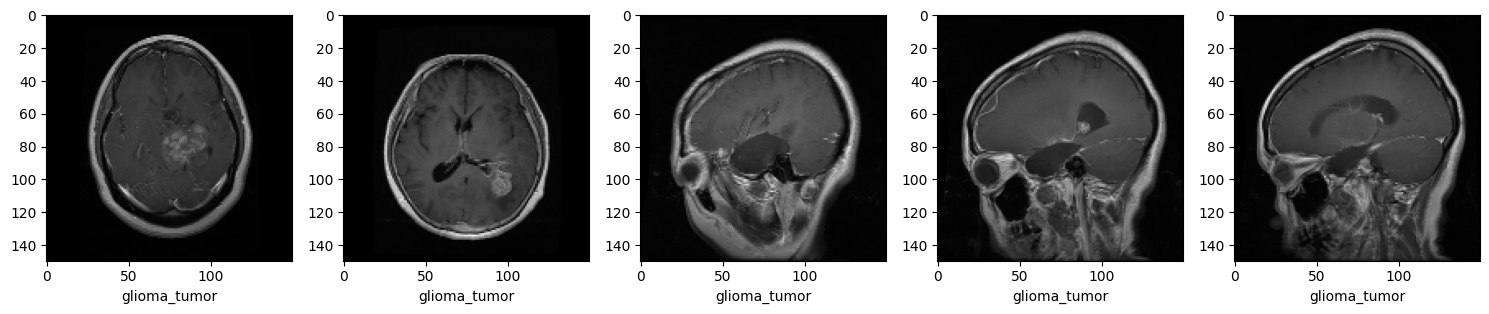

In [5]:
plt.figure(figsize = (15,15));
for i,j in enumerate(train_img):
    if i<5:
        plt.subplot(1,5,i+1)
        plt.imshow(j);
        plt.xlabel(train_labels[i]);
        plt.tight_layout()
    else:
        break

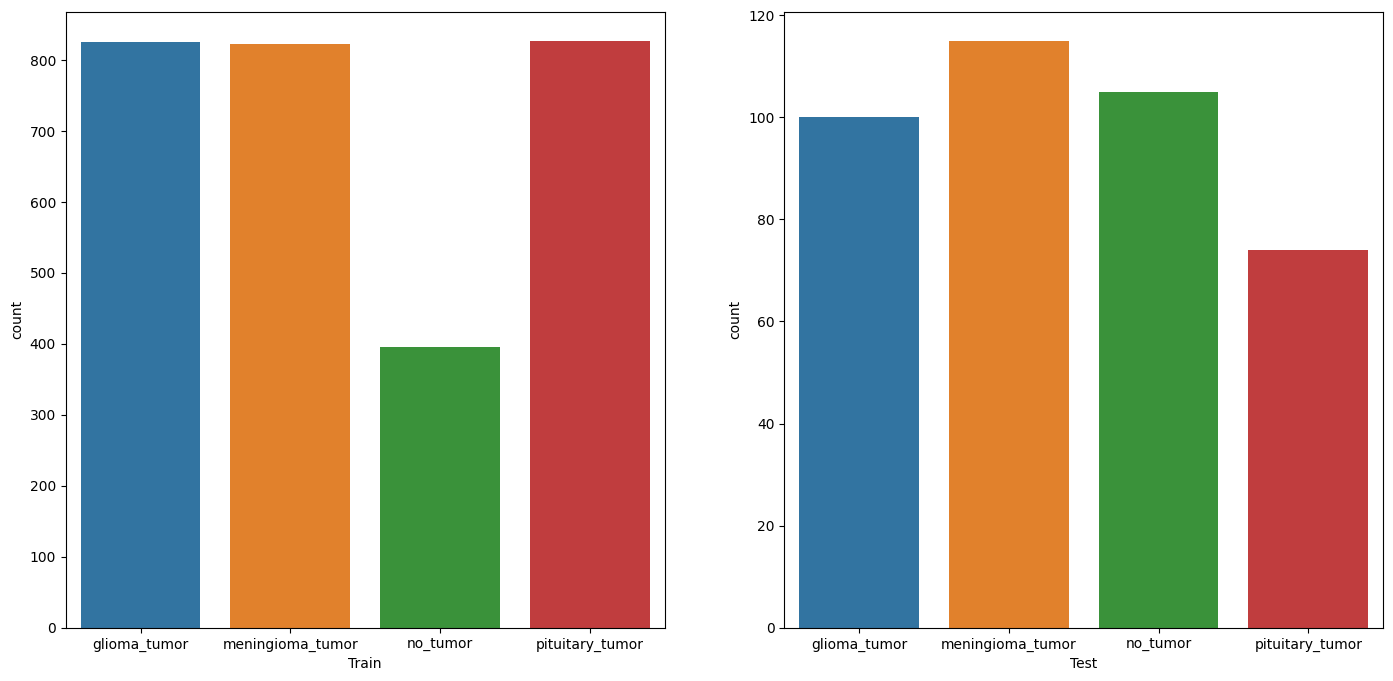

In [6]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

## Modelling

In [7]:
train_x, val_x, train_y, val_y = train_test_split(np.array(train_img), np.array(train_labels), test_size = 0.1)
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((2583, 150, 150, 3), (2583,), (287, 150, 150, 3), (287,))

In [8]:
# Adding padding here to preserve the image shape
# Adding maxpool layer to get those pixels which have the highest intensity. Reduces the image size by 2.
# Took filters of 77 as image size if 300 300 thus it would help it to learn better.
# Taken a dropout layer, to avoid overfitting.


model = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(kernel_size=(5,5) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3),filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3) ,filters=64, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(4, activation='sigmoid')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

2023-09-10 11:12:29.014365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-10 11:12:29.015638: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
# The image from data generator is of type 'uint8', you need to type cast it to 'float32'.

history = model.fit(tf.cast(train_img, tf.float32),
                    np.array(pd.get_dummies(train_labels)),
                    validation_split=0.1, epochs =10, verbose=1, batch_size=32)

2023-09-10 11:12:29.424672: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 774900000 exceeds 10% of free system memory.
2023-09-10 11:12:29.679182: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 697410000 exceeds 10% of free system memory.


Epoch 1/10
81/81 [==============================] - 53s 629ms/step - loss: 2.2919 - accuracy: 0.4692 - val_loss: 1.2830 - val_accuracy: 0.3031
Epoch 2/10
81/81 [==============================] - 49s 602ms/step - loss: 0.9105 - accuracy: 0.6074 - val_loss: 1.0350 - val_accuracy: 0.5401
Epoch 3/10
81/81 [==============================] - 51s 633ms/step - loss: 0.7931 - accuracy: 0.6636 - val_loss: 0.9777 - val_accuracy: 0.5331
Epoch 4/10
81/81 [==============================] - 45s 561ms/step - loss: 0.7206 - accuracy: 0.7023 - val_loss: 0.7877 - val_accuracy: 0.6829
Epoch 5/10
81/81 [==============================] - 43s 532ms/step - loss: 0.6076 - accuracy: 0.7379 - val_loss: 0.8707 - val_accuracy: 0.6620
Epoch 6/10
81/81 [==============================] - 41s 506ms/step - loss: 0.5549 - accuracy: 0.7774 - val_loss: 0.6895 - val_accuracy: 0.7666
Epoch 7/10
81/81 [==============================] - 44s 541ms/step - loss: 0.5100 - accuracy: 0.7933 - val_loss: 0.7028 - val_accuracy: 0.7282

## test on random test img